In [2]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.optim import AdamW
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
# Retina
%config InlineBackend.figure_format = 'retina'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
device

device(type='mps')

In [4]:
def make_diag_zero(mat):

    for i in range(mat.shape[0]):

        mat[i][i] = 0
    
    return mat

#### Download data

In [5]:
root = "./data/"

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root=root, train=True,
                                         download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(root=root, train=False,
                                        download=False, transform=transform)

#### Data preprocessing

In [6]:
number_samples = [torch.where(train_dataset.targets==i)[0] for i in range(10)]

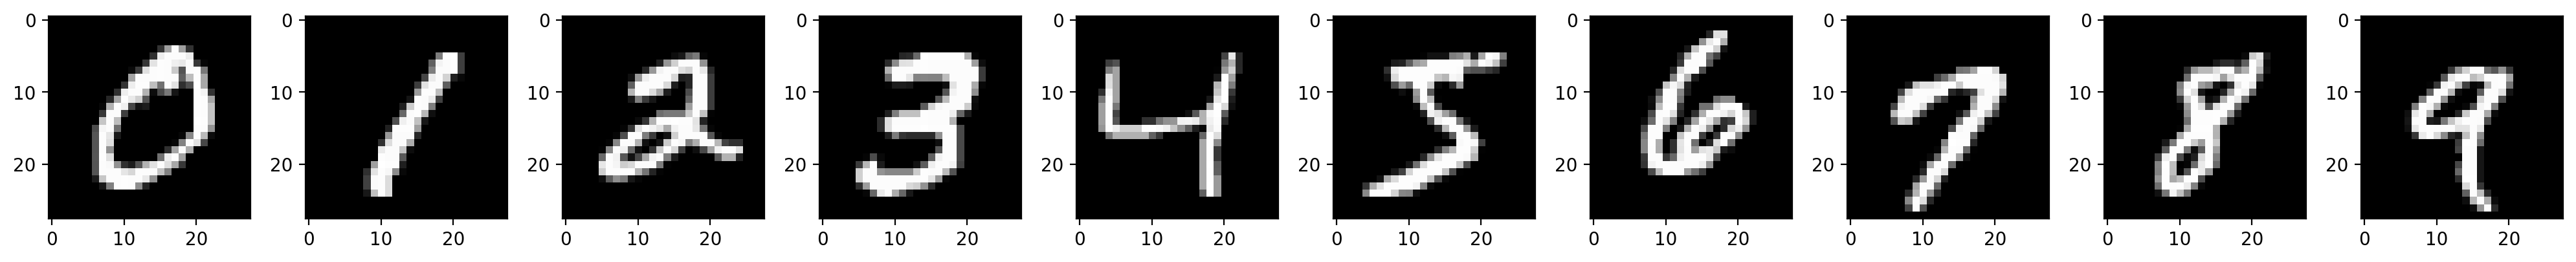

In [7]:
fig, axs = plt.subplots(1, 10, figsize=(20,10))

for i in range(10):

    axs[i].imshow(train_dataset.data[number_samples[i][0]], cmap="grey")

plt.tight_layout()

In [8]:
X_train = train_dataset.data.reshape((len(train_dataset), -1))
y_train = train_dataset.targets.to(torch.float32)

X_test = test_dataset.data.reshape((len(test_dataset), -1))
y_test = test_dataset.targets.to(torch.float32)

In [9]:
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

In [10]:
X_train_scaled.shape

torch.Size([60000, 784])

In [11]:
ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = torch.tensor(ohe.fit_transform(y_train.unsqueeze(-1)), dtype=torch.float32)
y_test_ohe = torch.tensor(ohe.transform(y_test.unsqueeze(-1)), dtype=torch.float32)

#### Model

In [12]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.Linear1 = torch.nn.Linear(784, 200, bias=True, dtype=torch.float32)
        self.Linear2 = torch.nn.Linear(200, 100, bias=True, dtype=torch.float32)
        self.Linear3 = torch.nn.Linear(100, 10, bias=True, dtype=torch.float32)

        self.lrelu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.4)

    def forward(self, X):

        X1 = self.dropout(self.lrelu(self.Linear1(X)))
        X2 = self.dropout(self.lrelu(self.Linear2(X1)))
        X3 = self.sigmoid(self.Linear3(X2))

        return (X1, X2, X3)


In [13]:
model = Model().to(device)

In [14]:
torch.save(model.state_dict(), "mlp_model.pth")

In [15]:
model1 = torch.load("mlp_model.pth")

/var/folders/jv/6j759gh52pjg5xgj136xc96w0000gn/T/ipykernel_9680/3162316771.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load("mlp_model.pth")


#### Training

In [16]:
torch.compile(model)

OptimizedModule(
  (_orig_mod): Model(
    (Linear1): Linear(in_features=784, out_features=200, bias=True)
    (Linear2): Linear(in_features=200, out_features=100, bias=True)
    (Linear3): Linear(in_features=100, out_features=10, bias=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (sigmoid): Sigmoid()
    (dropout): Dropout(p=0.4, inplace=False)
  )
)

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()

opt = AdamW(model.parameters(), lr=0.001)

batch_size = 10000
data_size = X_train.shape[0]

for epoch in range(100):
    loss_ = torch.zeros(data_size//batch_size)

    for iter in range(data_size//batch_size):

        x = X_train_scaled[iter*batch_size: (iter+1)*batch_size].to(device)
        y = y_train_ohe[iter*batch_size: (iter+1)*batch_size].to(device)

        pred = model(x)
        loss = loss_fn(pred[-1], y)

        loss_[iter] = loss.item()

        loss.backward()
        opt.step()
        opt.zero_grad()

        del x
        del y

    print(f"epoch {epoch} ---> loss: {loss_.mean()}")


epoch 0 ---> loss: 2.250933885574341
epoch 1 ---> loss: 2.090273857116699
epoch 2 ---> loss: 1.9201427698135376
epoch 3 ---> loss: 1.7841731309890747
epoch 4 ---> loss: 1.7060617208480835
epoch 5 ---> loss: 1.6623352766036987
epoch 6 ---> loss: 1.633331298828125
epoch 7 ---> loss: 1.6135249137878418
epoch 8 ---> loss: 1.5989528894424438
epoch 9 ---> loss: 1.588821530342102
epoch 10 ---> loss: 1.5791001319885254
epoch 11 ---> loss: 1.5725197792053223
epoch 12 ---> loss: 1.567647933959961
epoch 13 ---> loss: 1.5614300966262817
epoch 14 ---> loss: 1.557773470878601
epoch 15 ---> loss: 1.5541366338729858
epoch 16 ---> loss: 1.55152428150177
epoch 17 ---> loss: 1.5476735830307007
epoch 18 ---> loss: 1.5454670190811157
epoch 19 ---> loss: 1.5432003736495972
epoch 20 ---> loss: 1.542110800743103
epoch 21 ---> loss: 1.539544939994812
epoch 22 ---> loss: 1.5382438898086548
epoch 23 ---> loss: 1.5360788106918335
epoch 24 ---> loss: 1.534446120262146
epoch 25 ---> loss: 1.532585620880127
epoch 26

#### Testing

In [18]:
model.eval()

with torch.no_grad():

    y_pred_mlp = model(X_test_scaled.to(device))

y_pred_mlp = torch.argmax(y_pred_mlp[-1], dim=1).detach().cpu()

Accuracy: 0.9662
Precision: 0.9662
Recall: 0.9662
F1 Score: 0.9662


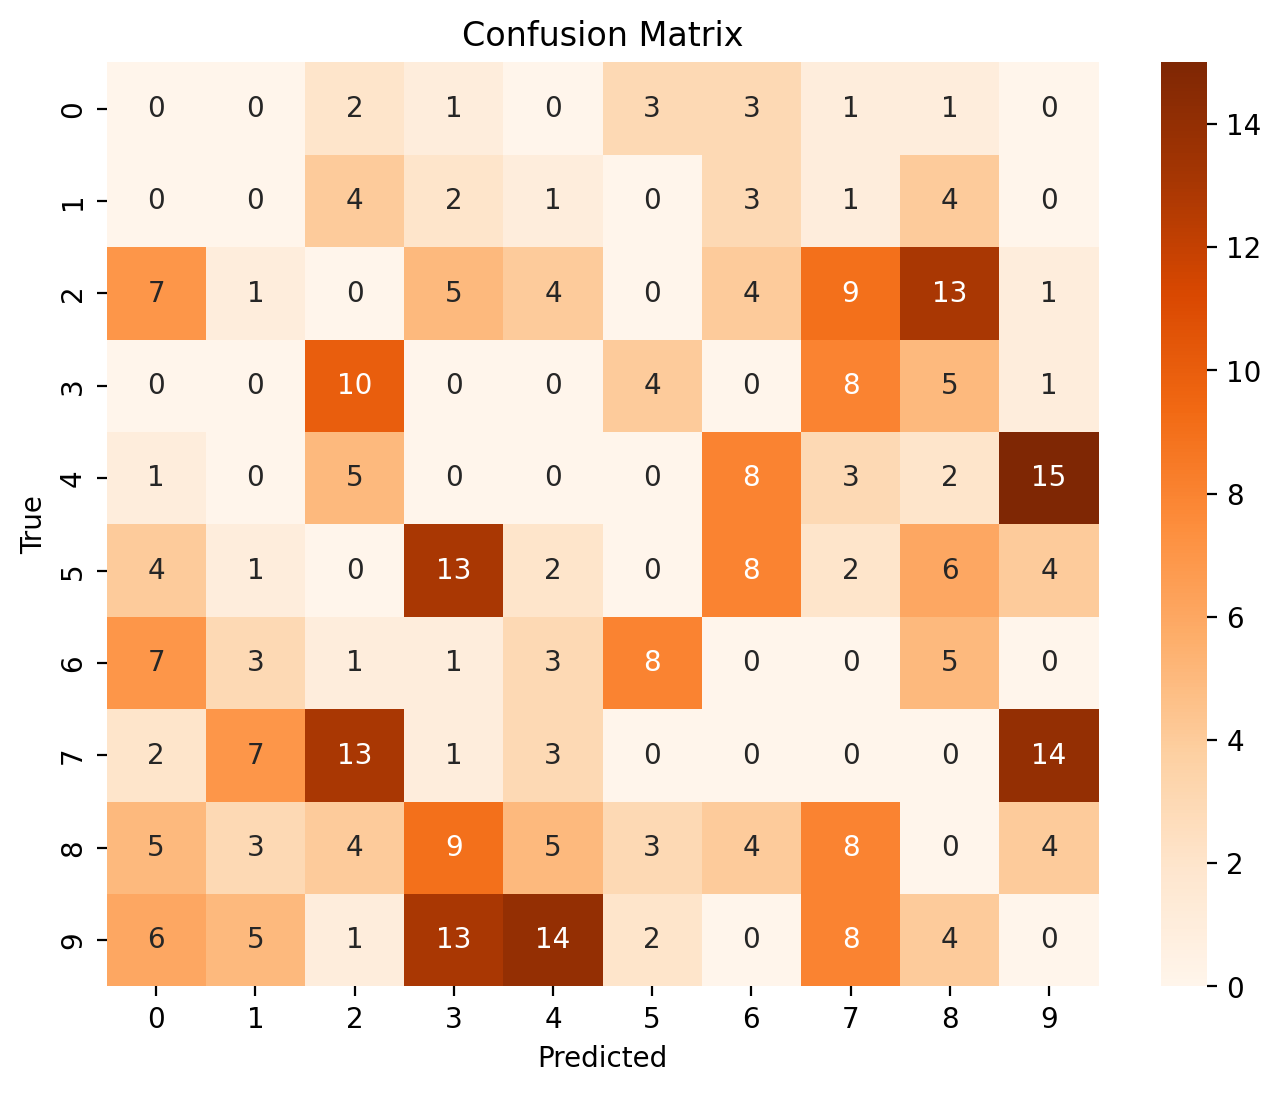

In [21]:
print(f"Accuracy: {accuracy_score(y_pred_mlp, y_test)}")
print(f"Precision: {precision_score(y_pred_mlp, y_test, average='micro')}")
print(f"Recall: {recall_score(y_pred_mlp, y_test, average='micro')}")
print(f"F1 Score: {f1_score(y_pred_mlp, y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(y_test, y_pred_mlp))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Random Forest

In [22]:
random_forest_classifier = RandomForestClassifier()

random_forest_classifier.fit(X_train_scaled, y_train)
y_pred_rf = random_forest_classifier.predict(X_test_scaled)

Accuracy: 0.9702
Precision: 0.9702
Recall: 0.9702
F1 Score: 0.9702


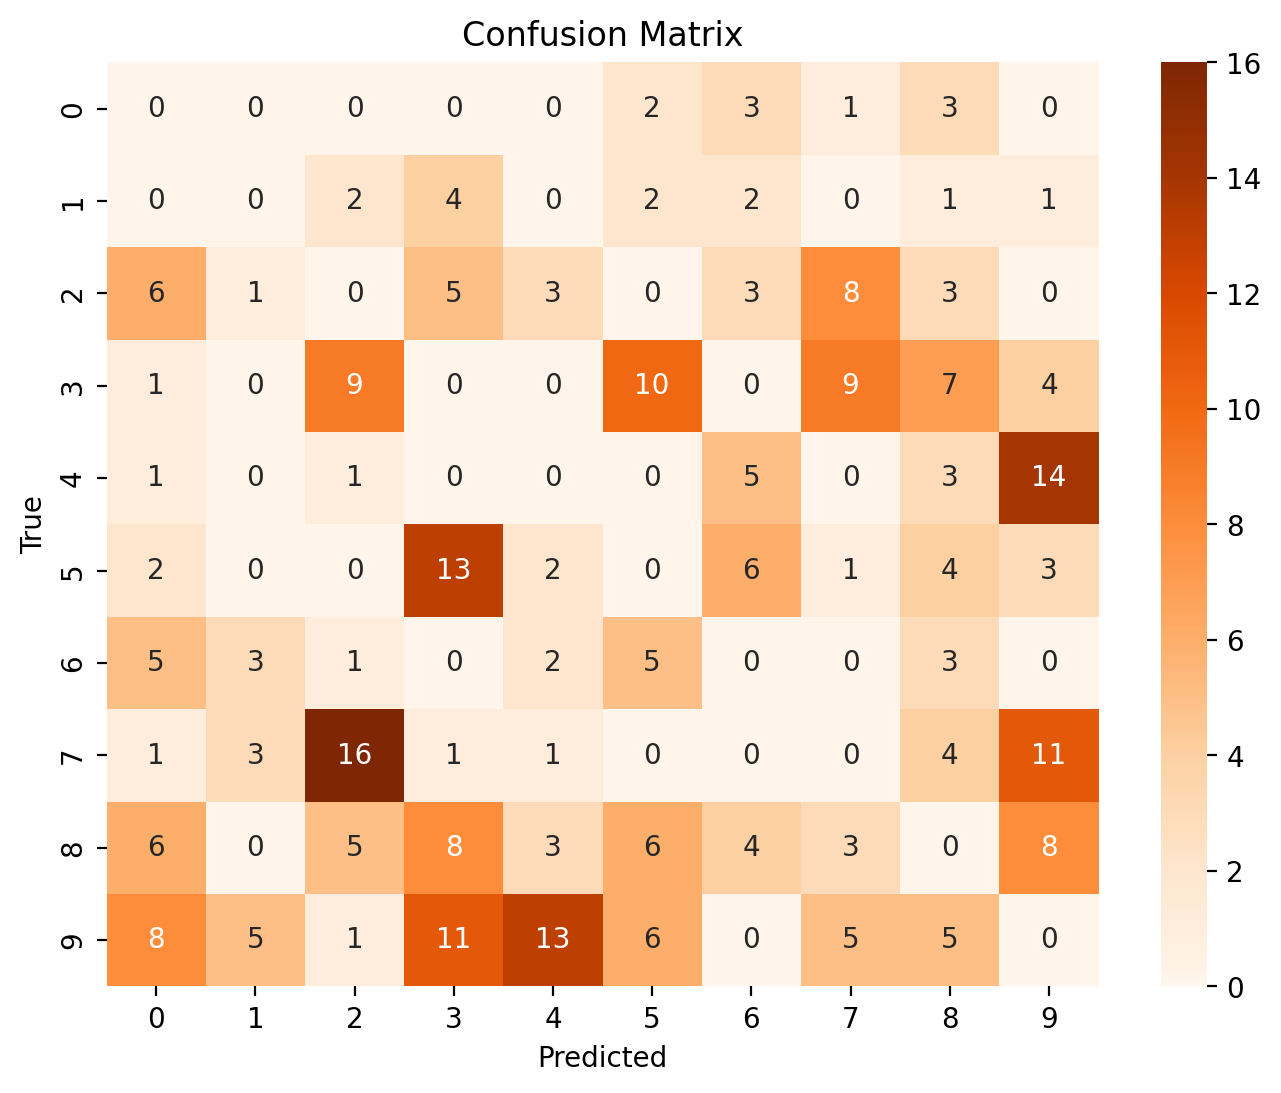

In [23]:
print(f"Accuracy: {accuracy_score(y_pred_rf, y_test)}")
print(f"Precision: {precision_score(y_pred_rf, y_test, average='micro')}")
print(f"Recall: {recall_score(y_pred_rf, y_test, average='micro')}")
print(f"F1 Score: {f1_score(y_pred_rf, y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Logistic regression

In [24]:
log_reg = LogisticRegression(solver='saga', max_iter=1000, multi_class='multinomial', n_jobs=-1)

log_reg.fit(X_train_scaled, y_train)

/Users/saileshpanda/Desktop/IITGN/.AI/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/saileshpanda/Desktop/IITGN/.AI/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='saga')

In [47]:
y_pred_lr = log_reg.predict(X_test_scaled)

Accuracy: 0.9261
Precision: 0.9261
Recall: 0.9261
F1 Score: 0.9261


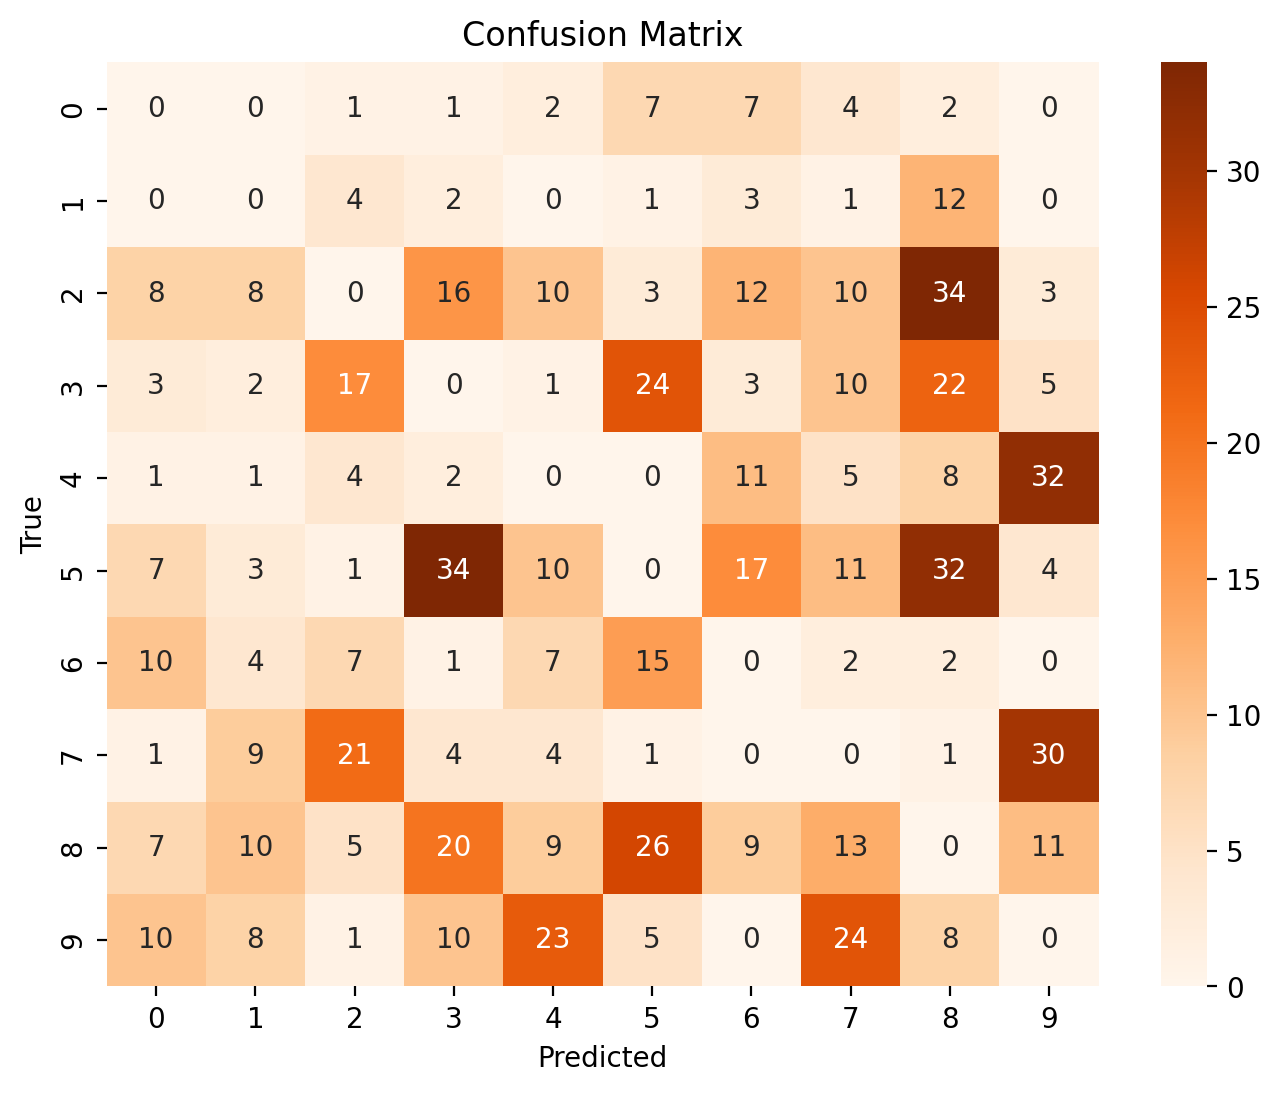

In [85]:
print(f"Accuracy: {accuracy_score(y_pred_lr, y_test)}")
print(f"Precision: {precision_score(y_pred_lr, y_test, average='micro')}")
print(f"Recall: {recall_score(y_pred_lr, y_test, average='micro')}")
print(f"F1 Score: {f1_score(y_pred_lr, y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(y_test, y_pred_lr))
#cm = np.log1p(confusion_matrix(y_test, y_pred_lr))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, #fmt="d",
             cmap="Oranges",
             xticklabels=range(10),
             yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### TSNE

In [106]:
for name, param in model.named_parameters():

    print(name)

Linear1.weight
Linear1.bias
Linear2.weight
Linear2.bias
Linear3.weight
Linear3.bias


In [148]:
with torch.no_grad():
    y = model(X_test_scaled.to(device))

In [160]:
tsne = TSNE(n_components=2, perplexity=3)
trained_y = tsne.fit_transform(y[1].squeeze(0).cpu())

In [239]:
model2 = Model()
model2.eval()
with torch.no_grad():

    untrained_pred = model2(X_test_scaled)

untrained_tsne = TSNE(n_components=2, perplexity=3)
untrained_y = untrained_tsne.fit_transform(untrained_pred[1].squeeze(0).cpu())

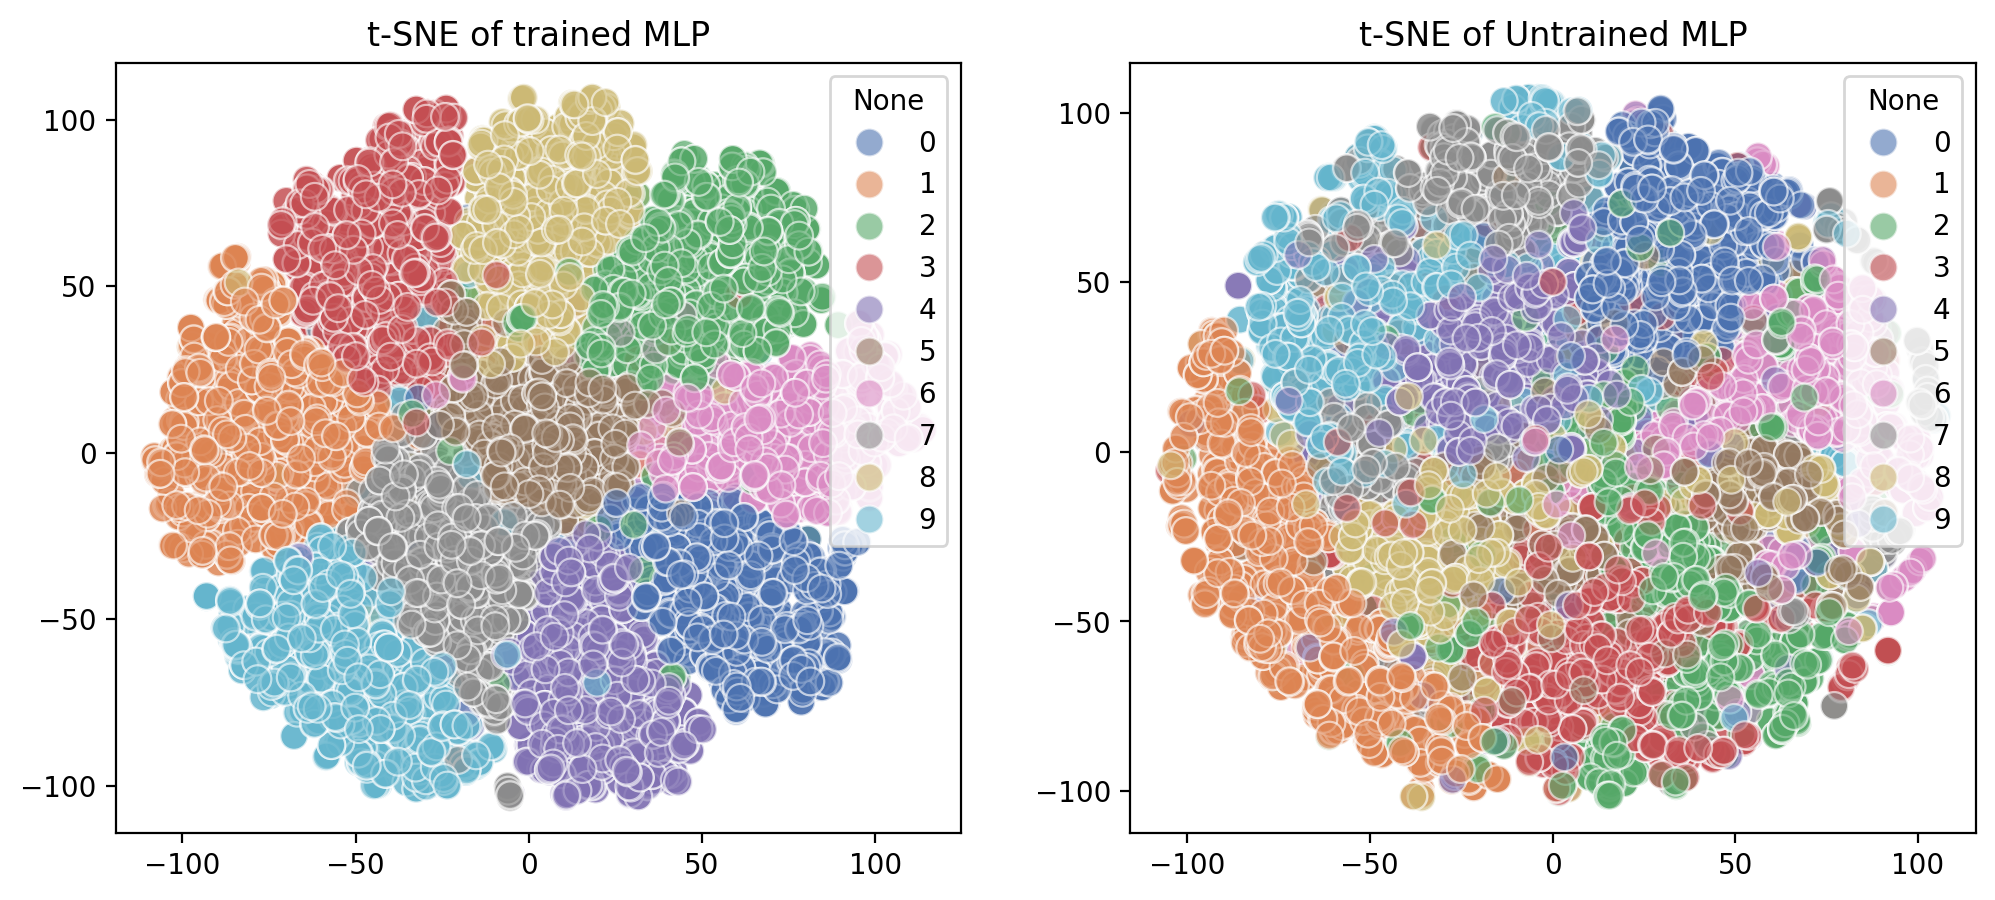

In [241]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))


sns.scatterplot(x=trained_y[:,0], y=trained_y[:,1], hue=y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=100, ax=axs[0])
axs[0].set_title("t-SNE of trained MLP")
sns.scatterplot(x=untrained_y[:,0], y=untrained_y[:,1], hue=y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=100, ax=axs[1])
axs[1].set_title("t-SNE of Untrained MLP")

plt.show()

### Fashion MNIST

In [25]:
fashion_mnist_test_dataset = torchvision.datasets.FashionMNIST(root=root, train=False,
                                        download=True, transform=transform)

In [26]:
fashion_mnist_test_dataset.data.shape

torch.Size([10000, 28, 28])

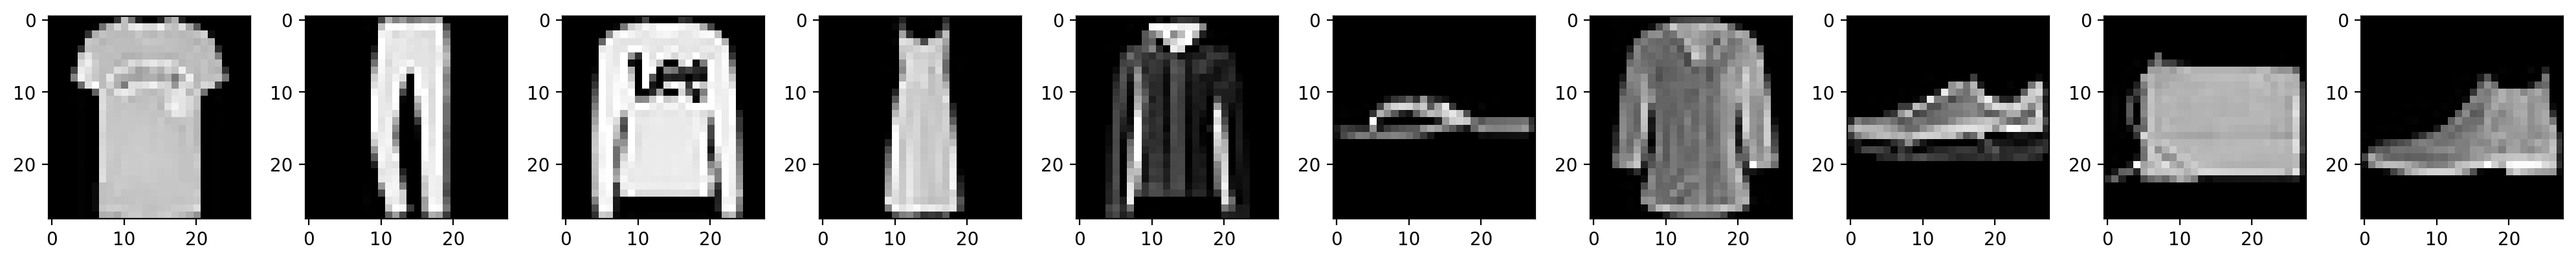

In [27]:
number_samples = [torch.where(fashion_mnist_test_dataset.targets==i)[0] for i in range(10)]

fig, axs = plt.subplots(1, 10, figsize=(20,10))

for i in range(10):

    axs[i].imshow(fashion_mnist_test_dataset.data[number_samples[i][0]], cmap="grey")

plt.tight_layout()

In [28]:
fm_X_test = fashion_mnist_test_dataset.data.reshape((len(fashion_mnist_test_dataset), -1))
fm_y_test = fashion_mnist_test_dataset.targets.to(torch.float32)

In [29]:
fn_X_test_scaled = torch.tensor(scaler.transform(fm_X_test), dtype=torch.float32)

Accuracy: 0.1219
Precision: 0.1219
Recall: 0.1219
F1 Score: 0.1219


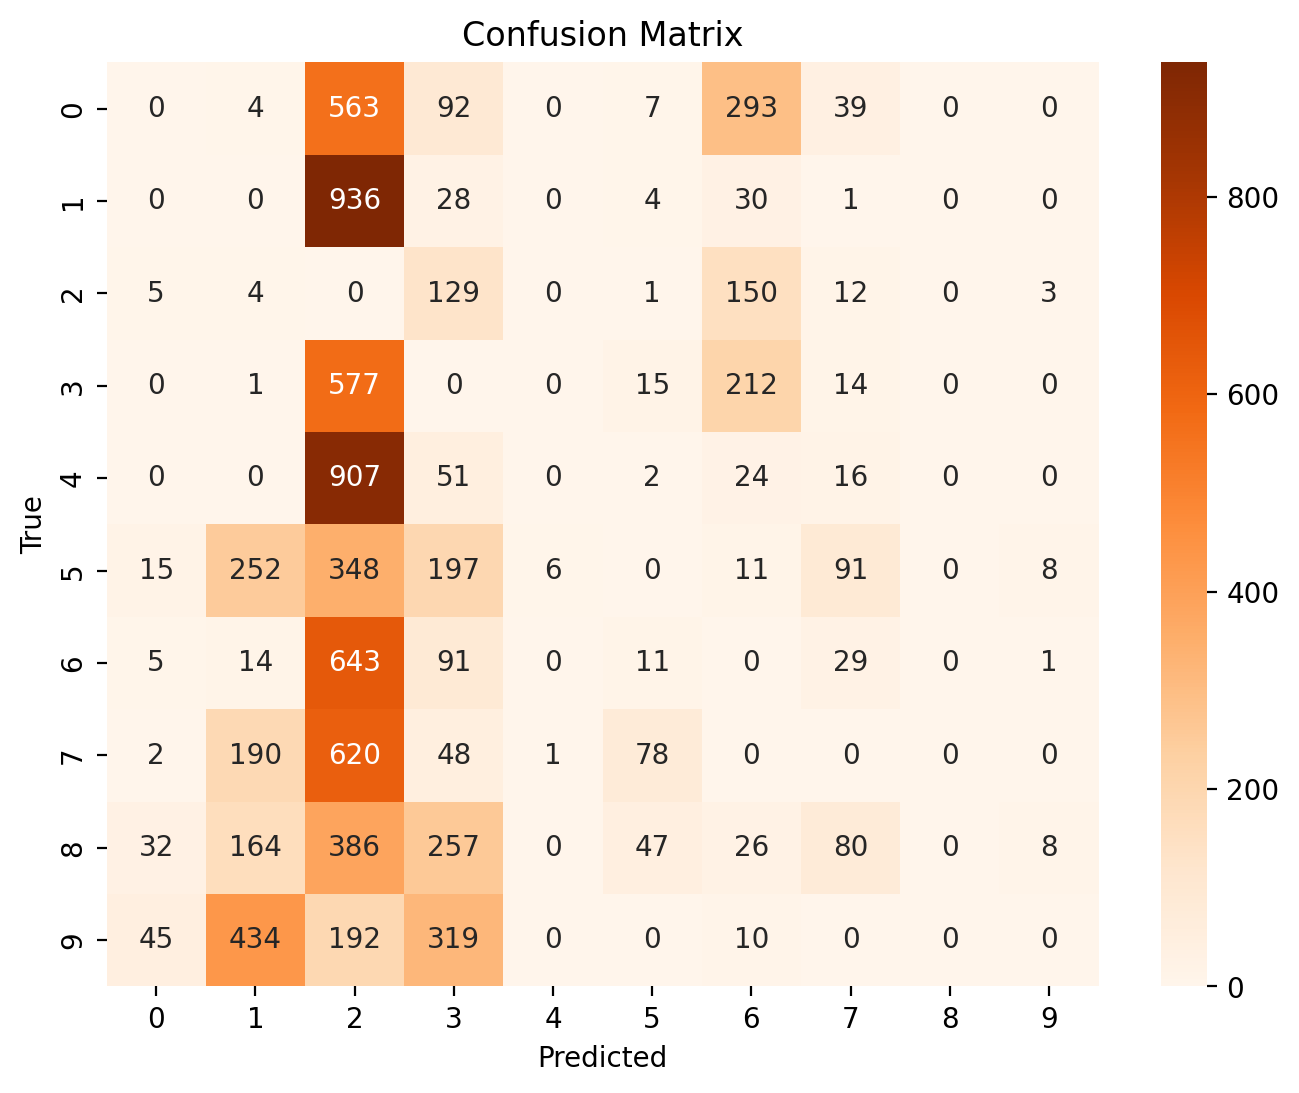

In [30]:
with torch.no_grad():

    fn_pred = model(fn_X_test_scaled.to(device))

fn_y_pred = torch.argmax(fn_pred[-1], dim=-1).cpu()
print(f"Accuracy: {accuracy_score(fn_y_pred, fm_y_test)}")
print(f"Precision: {precision_score(fn_y_pred, fm_y_test, average='micro')}")
print(f"Recall: {recall_score(fn_y_pred, fm_y_test, average='micro')}")
print(f"F1 Score: {f1_score(fn_y_pred, fm_y_test, average='micro')}")

cm = make_diag_zero(confusion_matrix(fm_y_test, fn_y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
             cmap="Oranges",
             xticklabels=range(10),
             yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

##### tSNE

In [221]:
fm_tsne = TSNE(n_components=2, perplexity=3)
fm_y = fm_tsne.fit_transform(fn_pred[1].squeeze(0).cpu())

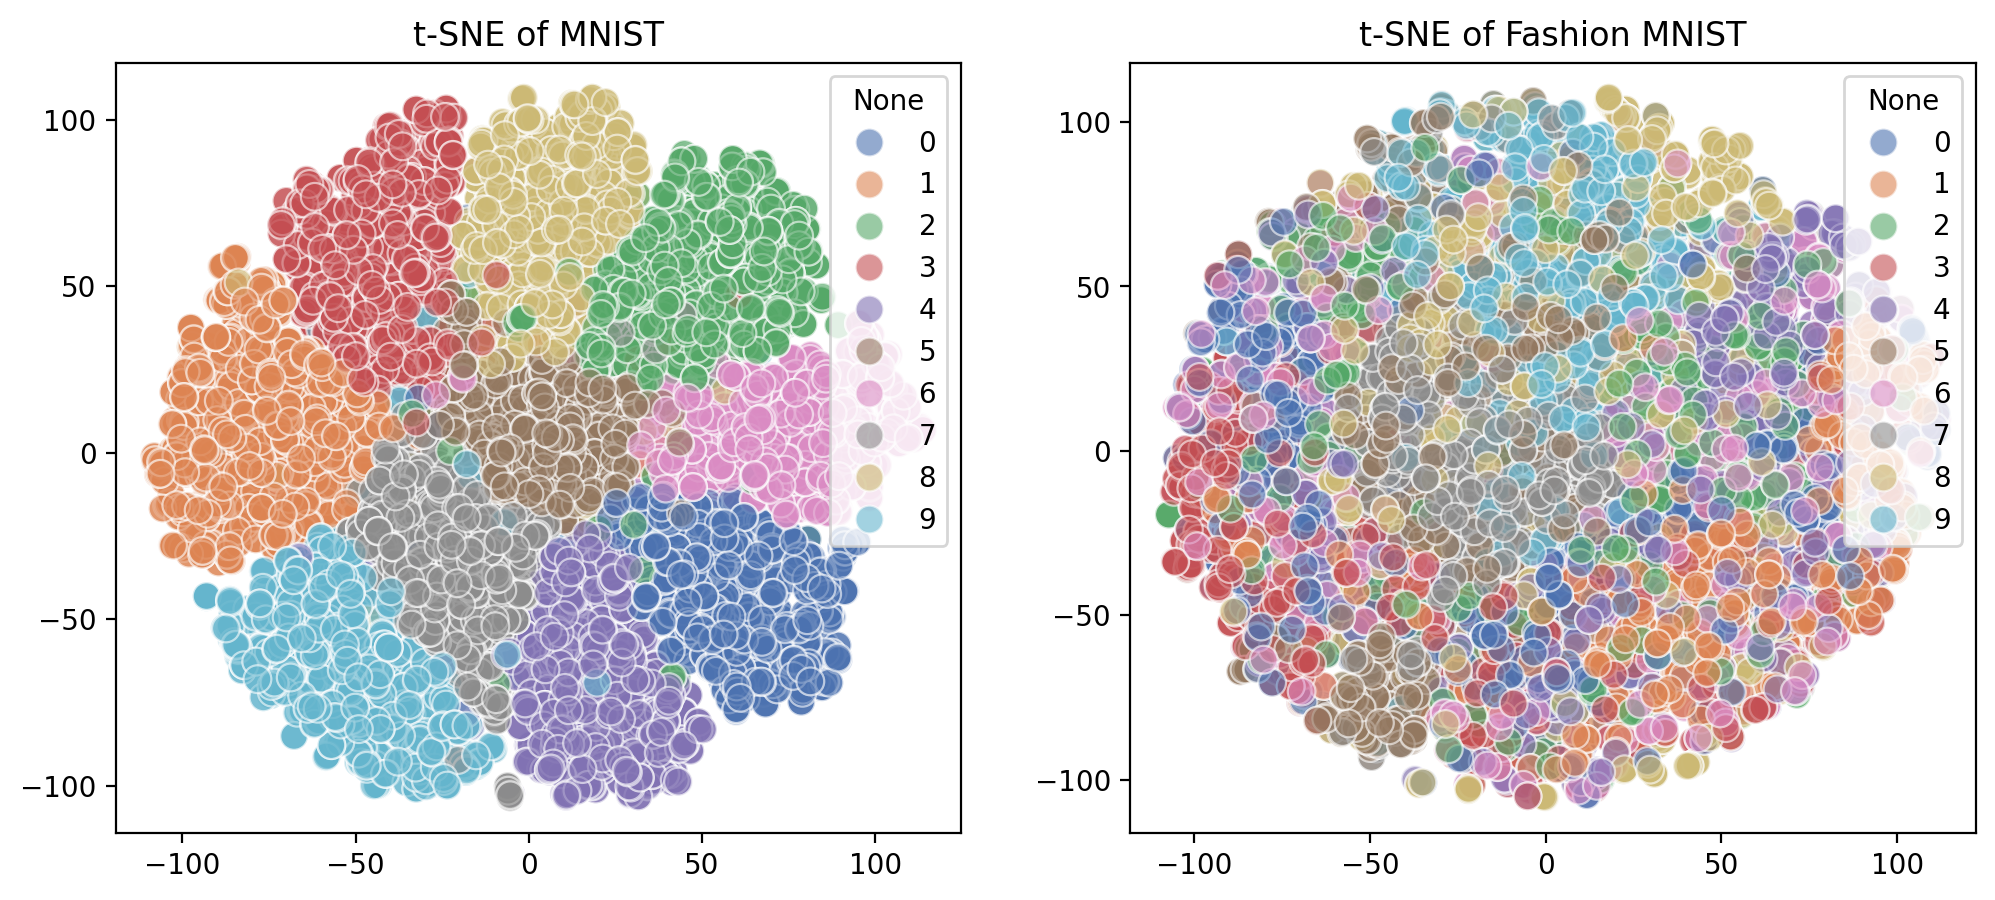

In [236]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))


sns.scatterplot(x=trained_y[:,0], y=trained_y[:,1], hue=y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=100, ax=axs[0])
axs[0].set_title("t-SNE of MNIST")
sns.scatterplot(x=fm_y[:,0], y=fm_y[:,1], hue=fm_y_test.to(int), palette='deep',
                            alpha=0.6,
                            s=100, ax=axs[1])
axs[1].set_title("t-SNE of Fashion MNIST")

plt.show()